In [1]:
!nvidia-smi

Tue Sep 28 12:36:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 472.12       Driver Version: 472.12       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A    0C    P5    24W /  N/A |    148MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, pipeline, GPTNeoForCausalLM, GPT2Tokenizer
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import csv
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import tqdm.notebook as tq
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transformers.logging.set_verbosity(transformers.logging.CRITICAL)

In [9]:
df = pd.read_csv("runs/03 EMNLP SAE-AAVE Pairs/sae_samples.tsv", sep='\t')
df.head()

,first_seg,second_seg
0,Manti Te'o was having a relationship via telep...,to be female.
1,The little girl is not going to win because i ...,she needs to stop what she is doing
2,He is upstairs rights now and I'm down here ge...,to go down. Nite nite.
3,"Shit, I am who I am. I'm done apologizing. I'm...","and if you don't like it, get out"
4,"It is very rare that I get what I want, but no...","losing it, no matter the cost"


In [4]:
df.shape
df.info

<bound method DataFrame.info of                                               first_seg  \
0     Manti Te'o was having a relationship via telep...   
1     The little girl is not going to win because i ...   
2     He is upstairs rights now and I'm down here ge...   
3     Shit, I am who I am. I'm done apologizing. I'm...   
4     It is very rare that I get what I want, but no...   
...                                                 ...   
2014  At least I'm happy with knowing I'm always coo...   
2015  I love when you ad-lib, if that's what you cal...   
2016  In search of a nice place to do karaoke or dis...   
2017  I am looking for an establishment that has a "...   
2018  I thought I hung up the phone when I went into...   

                                             second_seg  
0                                         to be female.  
1                   she needs to stop what she is doing  
2                                to go down. Nite nite.  
3                     and i

In [9]:
# sns.countplot(df.label)
# plt.xlabel('label (1: AAVE; 0: SAE)');

In [5]:
PRE_TRAINED_MODEL_NAME = 'EleutherAI/gpt-neo-1.3B'
tokenizer = GPT2Tokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = GPTNeoForCausalLM.from_pretrained(PRE_TRAINED_MODEL_NAME)

C:\Users\stwan\Miniconda3\envs\GPT_Dialect\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


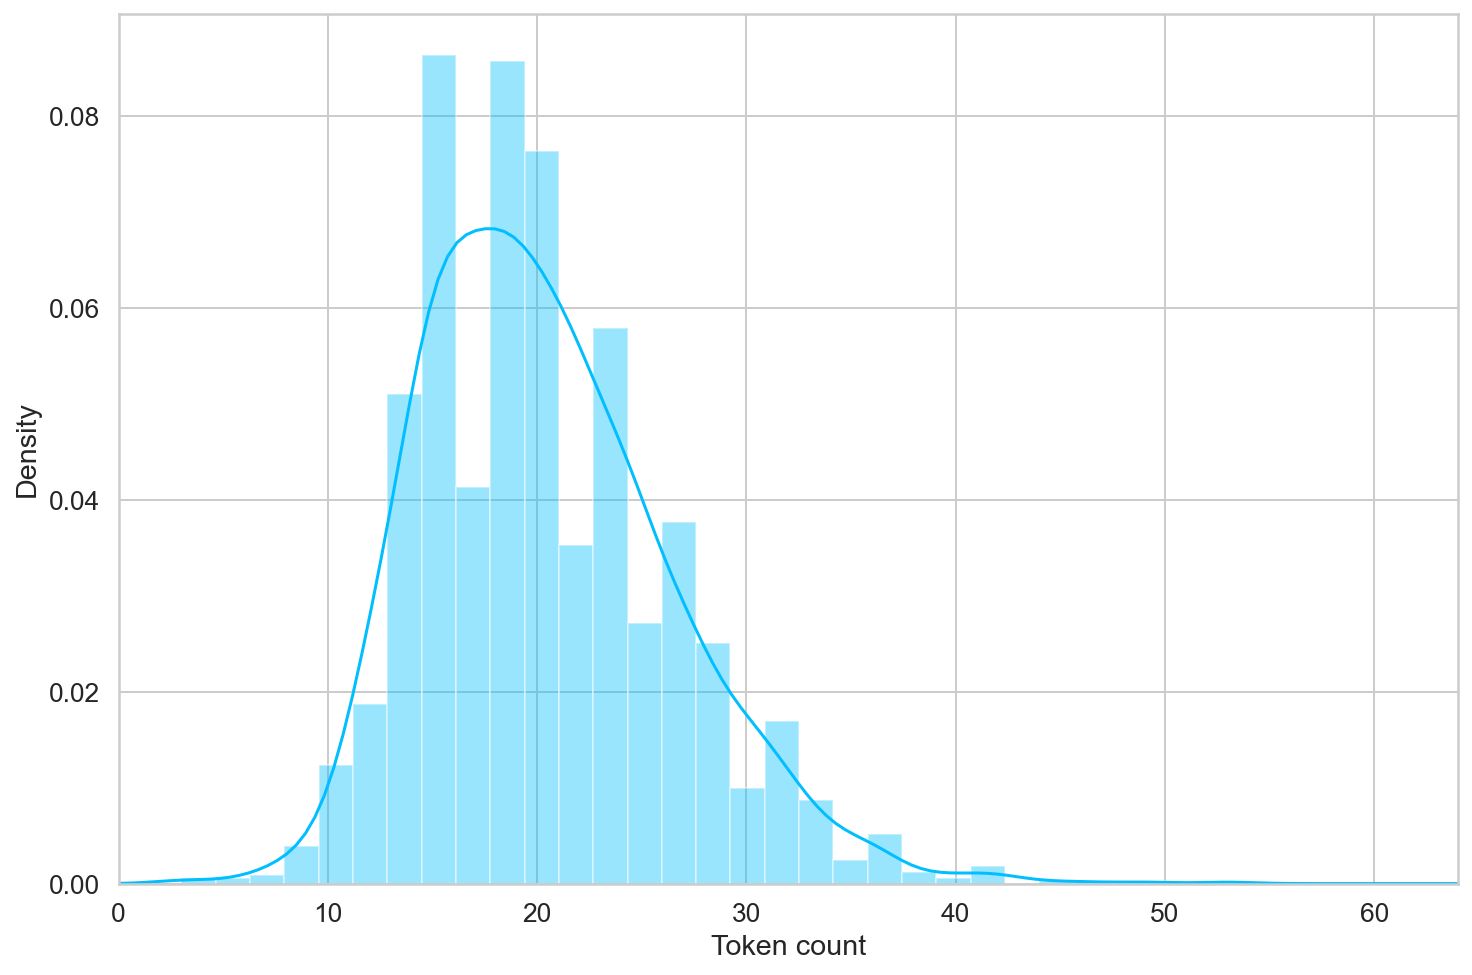

In [6]:
token_lens = []
for txt in df.first_seg:
    tokens = tokenizer.encode(txt, max_length=256)
    token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 64]);
plt.xlabel('Token count');

In [10]:
model.to("cuda:0")
with open('runs/03 EMNLP SAE-AAVE Pairs/sae_gen_txt.csv', 'a', encoding="utf-8") as f:
    writer = csv.writer(f)
    for i, txt in enumerate(tq.tqdm(df.first_seg)):
        input_ids = tokenizer(txt, return_tensors="pt").input_ids.cuda()
        gen_tokens = model.generate(input_ids, do_sample=True, max_length=(5 + input_ids.shape[1]))
        gen_txt = tokenizer.batch_decode(gen_tokens[:, -5:])
        writer.writerow([i, gen_txt])

  0%|          | 0/2019 [00:00<?, ?it/s]